In [ ]:
!find ../../images-desi-lowz -type f -print0 | xargs -0 ls -l | awk '{size[int(log($5)/log(2))]++}END{for (i in size) printf("%10d %3d\n", 2^i, size[i])}' | sort -n

         0   5
      1024 102
      2048  23
      4096 128
      8192 144239
     16384 2222705
     32768  80

# Prediction time

In [1]:
from fastai2.basics import *
from fastai2.vision.all import *
from pathlib import Path

from mish_cuda import MishCuda
import cmasher as cmr
import gc
import scipy.cluster.hierarchy as hcluster

from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, roc_curve

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import tqdm.notebook as tqdm

seed = 256

%matplotlib inline

In [2]:
import sys
PATH = Path('../..').resolve()

sys.path.append(f'{PATH}/src')
from utils import *

learner_metrics = [accuracy, F1Score(), Recall(), Precision()]

sys.path.append('/home/jupyter/morphological-spectra/src')
from xresnet_deconv import *

# Loading previous results

In [3]:

# https://github.com/fastai/fastai/blob/master/fastai/losses.py#L48
class FocalLossFlat(CrossEntropyLossFlat):
    """
    Same as CrossEntropyLossFlat but with focal paramter, `gamma`. Focal loss is introduced by Lin et al.
    https://arxiv.org/pdf/1708.02002.pdf. Note the class weighting factor in the paper, alpha, can be
    implemented through pytorch `weight` argument in nn.CrossEntropyLoss.
    """
    y_int = True
    @use_kwargs_dict(keep=True, weight=None, ignore_index=-100, reduction='mean')
    def __init__(self, *args, gamma=2, axis=-1, **kwargs):
        self.gamma = gamma
        self.reduce = kwargs.pop('reduction') if 'reduction' in kwargs else 'mean'
        super().__init__(*args, reduction='none', axis=axis, **kwargs)
    def __call__(self, inp, targ, **kwargs):
        ce_loss = super().__call__(inp, targ, **kwargs)
        pt = torch.exp(-ce_loss)
        fl_loss = (1-pt)**self.gamma * ce_loss
        return fl_loss.mean() if self.reduce == 'mean' else fl_loss.sum() if self.reduce == 'sum' else fl_loss


In [4]:
saga = pd.read_csv(f'{PATH}/data/saga_redshifts_2021-02-19.csv', dtype={'OBJID': str})

df = saga.sample(frac=1, random_state=seed).copy()
df['low_z'] = df.SPEC_Z < 0.03

# in order to use with previous utils
df['SPEC_FLAG'] = 1

In [5]:
label_column = 'low_z'

# focal loss weight params
gamma = 2
loss_func = FocalLossFlat(gamma=gamma)

In [6]:
sz = 144
bs = 128

img_dir = 'images-legacy_saga-2021-02-19'

legacy_image_stats = [np.array([0.14814416, 0.14217226, 0.13984123]), np.array([0.0881476 , 0.07823102, 0.07676626])]

item_tfms = [Resize(sz)]
batch_tfms = (
    aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.) + 
    [Normalize.from_stats(*legacy_image_stats)]
)

seed = 256  

In [7]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader(['OBJID'], pref=f'{PATH}/images-legacy_saga-2021-02-19/', suff='.jpg'),
    get_y=ColReader('low_z'),
    splitter=RandomSplitter(0),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=bs)

model = xresnet34_hybrid(n_out=2, sa=True, act_cls=MishCuda, groups=64, reduction=8)
learn = Learner(
    dls, model, 
    opt_func=ranger, 
    loss_func=loss_func,
)
learn.load(f'{PATH}/models/desi-sv_FL-hdxresnet34-sz{sz}');

# Load images and predict

In [10]:
filenames = list(x for x in (PATH/'images-desi-lowz').rglob('*.jpg') if (x.stat().st_size >= 4096))

In [19]:
test_dl = dls.test_dl(filenames, num_workers=8, bs=32)

In [20]:
m = learn.model.eval()

outputs = []
with torch.no_grad():
    for (xb,) in tqdm.tqdm(iter(test_dl), total=len(test_dl)):
        outputs.append(m(xb).cpu())
        
outs = torch.cat(outputs)

In [22]:
ps = outs.softmax(1)

# Save predictions

In [24]:
# only keep relevant ones
object_names = np.array([x.stem for x in filenames])

In [42]:
# write to dataframe
preds = pd.DataFrame({'p_CNN': ps[:, 1]}, index=object_names)

In [44]:
# preds.to_csv(PATH/'results/desi-lowz/CNN-hdx34-sz144_2021-03-04.csv')

In [11]:
preds = pd.read_csv(PATH/'results/desi-lowz/CNN-hdx34-sz144_2021-03-04.csv', index_col=0)


p_CNN
22780600766249849   0.071085
303524806-57021610  0.253638
38067190-11448164   0.147973
22297915460394928   0.064862
18110631-15829892   0.383441

In [16]:
preds.index.rename('name', inplace=True)
preds.head()

p_CNN
name                        
22780600766249849   0.071085
303524806-57021610  0.253638
38067190-11448164   0.147973
22297915460394928   0.064862
18110631-15829892   0.383441

## WIP: Save into north and south

In [12]:
desi_north = pd.read_csv(PATH/'data/desi_low_z_target_list_north_dr9.csv', index_col=0)


In [24]:
desi_north.shape

(774775, 148)

In [13]:
desi_north['name'] = (desi_north.RA * 1000000).astype(int).astype(str) + (desi_north.DEC * 1000000).astype(int).astype(str)

In [20]:
desi_north.name

114       37019840-2734175
246       37048051-2717422
678       37131668-2695066
756       37148296-2697212
1023      37181168-2625361
                ...       
950824    3510271411290094
958684     351000151492280
958891     351018864542952
958892     351018895528924
959077     351033645590015
Name: name, Length: 774775, dtype: object

In [14]:
desi_north.head()

RELEASE  BRICKID    BRICKNAME  OBJID    TYPE         RA       DEC  \
114      9011   314676  b'0371m027'    125  b'EXP'  37.019841 -2.734175   
246      9011   314676  b'0371m027'    258  b'EXP'  37.048051 -2.717423   
678      9011   314676  b'0371m027'    700  b'REX'  37.131669 -2.695066   
756      9011   314676  b'0371m027'    779  b'EXP'  37.148297 -2.697213   
1023     9011   314676  b'0371m027'   1046  b'REX'  37.181169 -2.625362   

           RA_IVAR      DEC_IVAR       EBV  ...  z_err  r_fib_mag  u_mag  \
114   3.053340e+10  6.025484e+10  0.028114  ...   99.0  21.590014   99.0   
246   1.077153e+10  1.555823e+10  0.027381  ...   99.0  22.160279   99.0   
678   5.821827e+09  6.403100e+09  0.028587  ...   99.0  22.571179   99.0   
756   2.988050e+10  1.300981e+10  0.029043  ...   99.0  22.095843   99.0   
1023  4.709894e+09  4.872066e+09  0.028974  ...   99.0  22.656726   99.0   

      u_err  i_mag  i_err       mu_r  mu_r_err    bgs              name  
114    99.0   99.0   99.0  23.157320  0.045834  False  37019840-2734175  
246    99.0   99.0   99.0  23.575838  0.043117  False  37048051-2717422  
678    99.0   99.0   99.0  23.510659  0.043168  False  37131668-2695066  
756    99.0   99.0   99.0  23.652900  0.079657  False  37148296-2697212  
1023   99.0   99.0   99.0  23.731185  0.072533  False  37181168-2625361  

[5 rows x 148 columns]

In [27]:
preds_north = preds.reset_index().join(desi_north.set_index('name'), on='name', how='inner')
preds_north.shape

(482766, 149)

In [28]:
preds_north.sample(10)

name     p_CNN  RELEASE  BRICKID    BRICKNAME  OBJID  \
306097   26950022762993475  0.165533     9011   625946  b'2694p630'   2762   
568892   12030574134712253  0.255785     9011   519262  b'1203p347'   1939   
1206433  24203649364297218  0.381755     9011   629109  b'2420p642'   2417   
800580   29142983860646833  0.058891     9011   619859  b'2916p607'    918   
413881   27918431962740440  0.058343     9011   625304  b'2789p627'   3933   
2169528  11400937955932353  0.038468     9011   605079  b'1138p560'   4267   
1645677  19614084546746580  0.114776     9011   571921  b'1961p467'   1743   
215451   16683497936731359  0.167538     9011   528787  b'1667p367'   2990   
1177169  12630685738637666  0.037953     9011   537795  b'1264p387'    249   
1851060  26646752238361936  0.040526     9011   535975  b'2665p382'   1978   

           TYPE          RA        DEC       RA_IVAR  ...      z_mag  \
306097   b'SER'  269.500227  62.993475  2.268484e+11  ...  18.985886   
568892   b'SER'  120.305742  34.712253  8.564083e+09  ...  18.921868   
1206433  b'REX'  242.036493  64.297219  1.596434e+10  ...  19.950987   
800580   b'DEV'  291.429838  60.646834  1.828395e+10  ...  20.168234   
413881   b'REX'  279.184319  62.740441  1.154443e+10  ...  20.678527   
2169528  b'EXP'  114.009379  55.932353  4.441273e+10  ...  19.868956   
1645677  b'EXP'  196.140845  46.746580  3.590156e+10  ...  20.036579   
215451   b'EXP'  166.834980  36.731360  8.159165e+10  ...  19.821629   
1177169  b'SER'  126.306858  38.637666  9.012452e+10  ...  18.821037   
1851060  b'EXP'  266.467523  38.361937  1.688044e+10  ...  20.453408   

            z_err  r_fib_mag  u_mag  u_err  i_mag  i_err       mu_r  mu_r_err  \
306097   0.013143  20.973969   99.0   99.0   99.0   99.0  22.800218  0.019048   
568892   0.035486  22.711048   99.0   99.0   99.0   99.0  25.919323  0.026999   
1206433  0.042050  22.447495   99.0   99.0   99.0   99.0  23.620474  0.036527   
800580   0.052475  22.340332   99.0   99.0   99.0   99.0  25.368694  0.138496   
413881   0.067302  22.615179   99.0   99.0   99.0   99.0  23.437531  0.060679   
2169528  0.023820  21.981089   99.0   99.0   99.0   99.0  23.361817  0.033655   
1645677  0.023553  21.665274   99.0   99.0   99.0   99.0  23.165306  0.044039   
215451   0.020639  21.545374   99.0   99.0   99.0   99.0  22.919058  0.030145   
1177169  0.009053  21.253004   99.0   99.0   99.0   99.0  22.878807  0.015202   
1851060  0.043318  22.504357   99.0   99.0   99.0   99.0  24.029157  0.065440   

           bgs  
306097    True  
568892    True  
1206433  False  
800580   False  
413881   False  
2169528  False  
1645677  False  
215451   False  
1177169   True  
1851060  False  

[10 rows x 149 columns]

Text(0, 0.5, 'DEC')

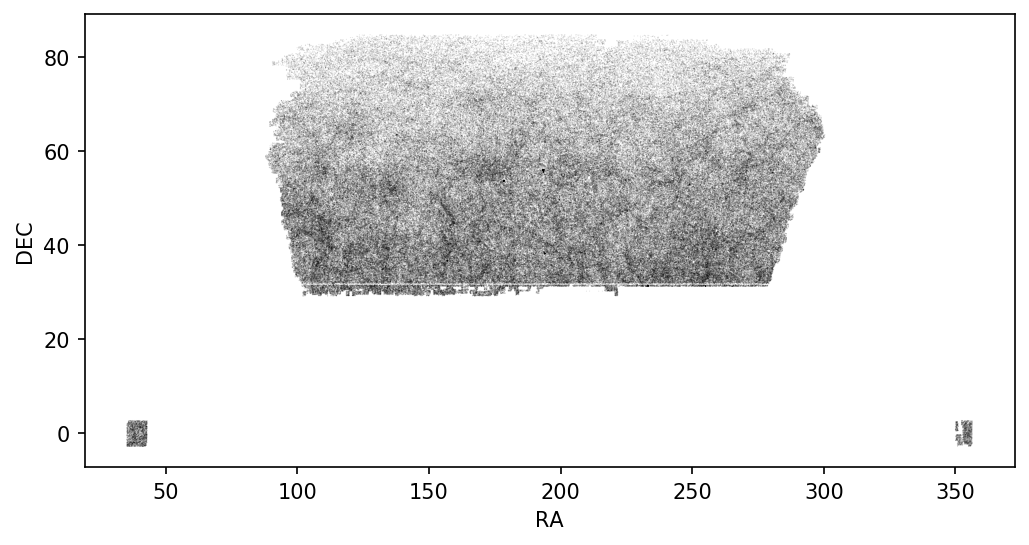

In [32]:
plt.figure(figsize=(8, 4), dpi=150)
plt.scatter(preds_north.RA, preds_north.DEC, s=0.3, color='k', edgecolor='none', alpha=0.1)

plt.xlim(*plt.xlim())
plt.xlabel('RA')
plt.ylabel('DEC')

So this covers about $\pi$ steradians, or about ~~10000~~ 5000 sq deg. We want around 20 per square deg, which is ~~**40,000 predictions**~~ **20,000**.

The catalog so far is incomplete, by the way...

In [35]:
preds_north.set_index('name', inplace=True)

In [36]:
# what are those things around DEC = 0?
preds_north[preds_north.DEC < 10].sample(20)[['RA', 'DEC', 'p_CNN']]

RA       DEC     p_CNN
name                                             
42619007-1160698    42.619008 -1.160699  0.061490
352644263-1971850  352.644264 -1.971851  0.036673
355175437-1842390  355.175437 -1.842391  0.017493
40382708-1783143    40.382708 -1.783143  0.046824
351289087-1804646  351.289087 -1.804646  0.099542
355577822605870    355.577823  0.605871  0.164684
41576538-1379812    41.576538 -1.379812  0.049392
37404631-725647     37.404632 -0.725647  0.068340
37299271-2048052    37.299272 -2.048053  0.041660
3504836151116322   350.483615  1.116322  0.041263
354060557-258844   354.060558 -0.258844  0.130483
38675427-967009     38.675427 -0.967009  0.098886
355174711-2571091  355.174712 -2.571092  0.080099
353223493787502    353.223493  0.787502  0.028675
36368688376593      36.368689  0.376593  0.021159
41057683623039      41.057684  0.623040  0.370574
403968631370047     40.396864  1.370048  0.050084
356133172444351    356.133173  0.444351  0.065631
352744359-1893928  352.744360 -1.893929  0.045987
3539976012158106   353.997602  2.158106  0.201511

Okay, they seem to be real. Not sure why they look like this.


In [39]:
for thresh in [0.7, 0.6, 0.5, 0.4, 0.3]:
    print(sum(preds_north.p_CNN > thresh))

919
3431
9589
21993
44004


So `p_CNN > 0.3` gets us to about 40k sources, or 20 per square degree. I think we'll have a higher density of sources though.

In [41]:
sats_north = preds_north.sort_values('p_CNN', ascending=False)
sats_north.head(10)[['RA', 'DEC', 'p_CNN']]

RA        DEC     p_CNN
name                                              
17492511231905593  174.925113  31.905594  0.982524
26680667044531039  266.806670  44.531039  0.900871
15694506736690981  156.945068  36.690982  0.895541
15698379636726984  156.983797  36.726985  0.894527
11637231275537788  116.372313  75.537788  0.875058
10959832850437682  109.598329  50.437683  0.871201
19337807655914248  193.378076  55.914249  0.870640
19336713155912785  193.367131  55.912786  0.870244
25040308075144726  250.403081  75.144727  0.869471
18509359239685315  185.093593  39.685315  0.869241

In [43]:
sats_north.iloc[300:320][['RA', 'DEC', 'p_CNN']]

RA        DEC     p_CNN
name                                              
19340207555924199  193.402076  55.924199  0.789224
17849051353747549  178.490514  53.747550  0.789221
17851458853644722  178.514589  53.644723  0.788172
20578515962575691  205.785160  62.575692  0.788170
27248140558364628  272.481406  58.364629  0.788098
15425842266141033  154.258422  66.141033  0.787935
18486805435960918  184.868055  35.960918  0.787459
19401247738234198  194.012477  38.234199  0.787180
22672782454533443  226.727824  54.533444  0.787030
16681898329936104  166.818984  29.936105  0.786656
19339595856036346  193.395958  56.036347  0.786629
15873951856330388  158.739518  56.330389  0.786332
16078114356321402  160.781144  56.321403  0.785689
23327967331339425  233.279674  31.339425  0.785527
13353780278140593  133.537803  78.140594  0.785521
23323582031408153  233.235821  31.408154  0.785243
17838458053757622  178.384580  53.757622  0.785241
12338782871801386  123.387828  71.801386  0.784683
13784481149880769  137.844811  49.880769  0.784521
26127837339069789  261.278373  39.069789  0.784459

# Removing junk by hand?
Ugh. Lots of junk next to the star [V* eps UMa](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=V%2A%20eps%20UMa)

In [44]:
# flagged sources: RA, DEC, radius (in deg)
junk = pd.DataFrame({
    'RA': [122.1800376477],
    'DEC': [61.1646463243],
    'radius': [1.0]
})

junk

RA        DEC  radius
0  122.180038  61.164646     1.0

Some more near \* tet CrB 

In [50]:
junk.append(
    pd.DataFrame(
        [
            [049.685004671, 54.714229604, 0.3], # * tet CrB
            [297.83430957, 61.32556549, 0.5],   # * gam Vir
            [140.8399133804, 61.3848823068, 0.5] # * gam UMa
        ], 
        columns=['RA', 'DEC', 'radius'],
    )
)

RA        DEC  radius
0  122.180038  61.164646     1.0
0   49.685005  54.714230     0.3
1  297.834310  61.325565     0.3

# Star bitmasks in DR9

In [92]:
print(sats_north.columns.values)

['p_CNN' 'RELEASE' 'BRICKID' 'BRICKNAME' 'OBJID' 'TYPE' 'RA' 'DEC'
 'RA_IVAR' 'DEC_IVAR' 'EBV' 'FLUX_G' 'FLUX_R' 'FLUX_Z' 'FLUX_W1' 'FLUX_W2'
 'FLUX_W3' 'FLUX_W4' 'FLUX_IVAR_G' 'FLUX_IVAR_R' 'FLUX_IVAR_Z'
 'FLUX_IVAR_W1' 'FLUX_IVAR_W2' 'FLUX_IVAR_W3' 'FLUX_IVAR_W4'
 'MW_TRANSMISSION_G' 'MW_TRANSMISSION_R' 'MW_TRANSMISSION_Z'
 'MW_TRANSMISSION_W1' 'MW_TRANSMISSION_W2' 'MW_TRANSMISSION_W3'
 'MW_TRANSMISSION_W4' 'NOBS_G' 'NOBS_R' 'NOBS_Z' 'NOBS_W1' 'NOBS_W2'
 'NOBS_W3' 'NOBS_W4' 'RCHISQ_G' 'RCHISQ_R' 'RCHISQ_Z' 'RCHISQ_W1'
 'RCHISQ_W2' 'RCHISQ_W3' 'RCHISQ_W4' 'FRACFLUX_G' 'FRACFLUX_R'
 'FRACFLUX_Z' 'FRACFLUX_W1' 'FRACFLUX_W2' 'FRACFLUX_W3' 'FRACFLUX_W4'
 'FRACMASKED_G' 'FRACMASKED_R' 'FRACMASKED_Z' 'FRACIN_G' 'FRACIN_R'
 'FRACIN_Z' 'ANYMASK_G' 'ANYMASK_R' 'ANYMASK_Z' 'ALLMASK_G' 'ALLMASK_R'
 'ALLMASK_Z' 'WISEMASK_W1' 'WISEMASK_W2' 'PSFSIZE_G' 'PSFSIZE_R'
 'PSFSIZE_Z' 'PSFDEPTH_G' 'PSFDEPTH_R' 'PSFDEPTH_Z' 'GALDEPTH_G'
 'GALDEPTH_R' 'GALDEPTH_Z' 'PSFDEPTH_W1' 'PSFDEPTH_W2' 'WISE_COADD_ID'


In [107]:
#  WISEM1 + WISEM2
2**8 + 2**9

768

In [103]:
sats_north.loc['17843117353743523'].MASKBITS

768

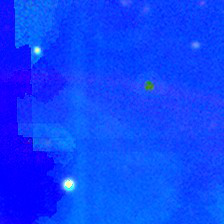

In [108]:
PILImage.create(f'{PATH}/images-desi-lowz/17843117353743523.jpg')

In [111]:
sats_north.loc['19342486855901256'].MASKBITS

768

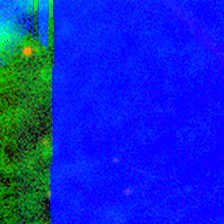

In [130]:
PILImage.create(f'{PATH}/images-desi-lowz/19342486855901256.jpg')

In [112]:
sats_north.MASKBITS

name
17492511231905593       0
26680667044531039       0
15694506736690981     768
15698379636726984     768
11637231275537788       0
                     ... 
22395001041138841    2048
20668477235974714    2048
13336507637064065       0
18912582256831966       0
13419873740208446    2048
Name: MASKBITS, Length: 482766, dtype: int64

In [114]:
2**11

2048

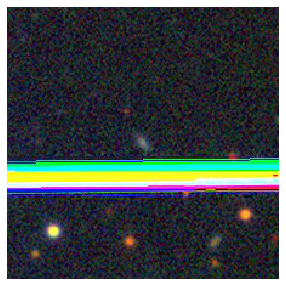

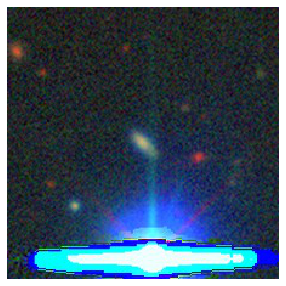

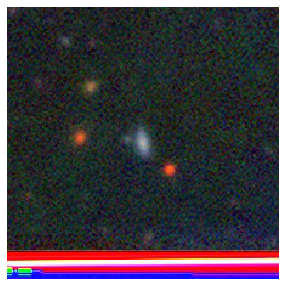

In [115]:
for objname in ['22395001041138841', '20668477235974714', '13419873740208446']:
    PILImage.create(f'{PATH}/images-desi-lowz/{objname}.jpg').show()

Visualize some of these masks

In [132]:
MASKBITS_WISE = sats_north[(sats_north.MASKBITS & (256 | 512)) != 0]
MASKBITS_WISE.shape

(20519, 148)

In [125]:
MASKBITS_WISE.sample(20)[['RA', 'DEC', 'MASKBITS']]

RA        DEC  MASKBITS
name                                              
22929971747782285  229.299717  47.782286       512
25963193032641612  259.631931  32.641612       256
24660588861793827  246.605888  61.793827       256
17853965957977534  178.539659  57.977534       256
19340394755915249  193.403948  55.915249       768
9977263578008653    99.772636  78.008653      2816
12369596037569153  123.695960  37.569153       256
21920578348233422  219.205784  48.233423      2304
19832833656257379  198.328336  56.257380       256
26207263345823088  262.072634  45.823088       256
19346693956050635  193.466940  56.050636       768
11101204535703385  111.012045  35.703385       768
18529536357869642  185.295364  57.869642      2816
17984113652626595  179.841136  52.626596       768
24989545748577903  249.895457  48.577904       768
28130434636821323  281.304347  36.821323       512
15702900463178307  157.029004  63.178308      2304
18670469469351174  186.704695  69.351174       256
25981758833234216  259.817588  33.234217       768
20622368533619730  206.223685  33.619731       256

Well that's not really correct.

In [127]:
MASKBITS_BRIGHT = sats_north[(sats_north.MASKBITS & (2**1)) != 0]
MASKBITS_BRIGHT.shape

(0, 148)

# Find them by spatial correlation

(300, 90)

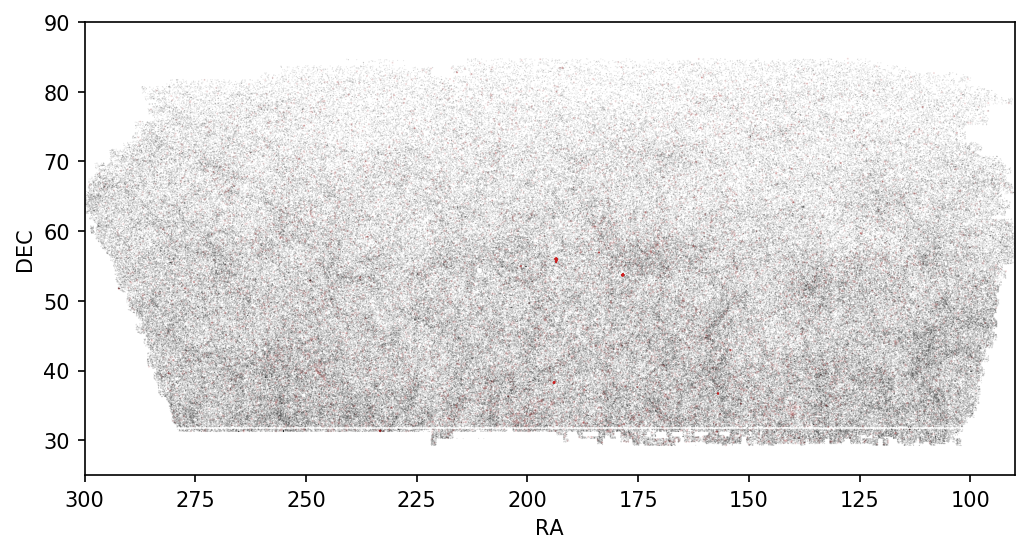

In [136]:
plt.figure(figsize=(8, 4), dpi=150)
plt.scatter(preds_north.RA, preds_north.DEC, s=0.3, color='k', edgecolor='none', alpha=0.1)
plt.scatter(preds_north[preds_north.p_CNN > 0.5].RA, preds_north[preds_north.p_CNN > 0.5].DEC, s=1, color='C3', edgecolor='none', alpha=0.1)

plt.xlim(*plt.xlim())
plt.xlabel('RA')
plt.ylabel('DEC')

plt.ylim(25, 90)
plt.xlim(300, 90)

# Or I can try to manually flag a bunch of these (for training yet another CNN...)

In [55]:
# sats_north[['RA', 'DEC', 'p_CNN']].to_csv(f'{PATH}/results/desi-lowz/preds_north_ranked-for_junk_removal.csv')

In [109]:
junk_df.sample(5)

objname          RA        DEC   junk
426   21964540166451445  219.645402  66.451445  False
360   19342486855901256  193.424869  55.901256   True
1807  12097660961974221  120.976610  61.974221  False
935   27528005452710695  275.280054  52.710696  False
18    12763463076967127  127.634631  76.967127  False

In [69]:
junk_df = pd.read_csv(f'{PATH}/results/desi-lowz/legacy-dr9_junk-classification.csv')
junk_df.rename({'name': 'objname'}, axis=1, inplace=True)
junk_df.sample(5)

objname          RA        DEC   junk
140   17843117353743523  178.431174  53.743523   True
762   27523598260877244  275.235982  60.877245  False
545   20833439237203213  208.334393  37.203213  False
713   20879407035730757  208.794070  35.730757  False
1895  14371799246662830  143.717992  46.662830  False

In [70]:
loss_func = FocalLossFlat(gamma=2)

In [139]:
dblock_junk = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader(['objname'], pref=f'{PATH}/images-desi-lowz/', suff='.jpg'),
    get_y=ColReader('junk'),
    splitter=RandomSplitter(0.3),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls_junk = ImageDataLoaders.from_dblock(dblock_junk, junk_df, path=PATH, bs=bs)

model_junk = xresnet34_hybrid(n_out=2, sa=True, act_cls=MishCuda, groups=64, reduction=8)
learn_junk = Learner(
    dls_junk, model_junk, 
    opt_func=ranger, 
    loss_func=loss_func,
    metrics=[accuracy]
)
learn_junk.load(f'{PATH}/models/desi-sv_FL-hdxresnet34-sz{sz}');

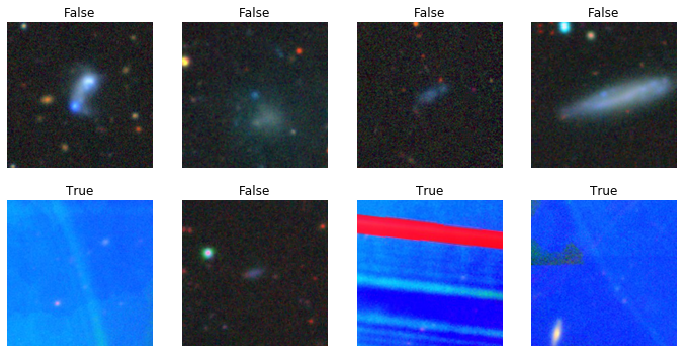

In [84]:
dls_junk.show_batch(max_n=8)

In [140]:
learn_junk.freeze()
learn_junk.fit_one_cycle(5, 3e-2)

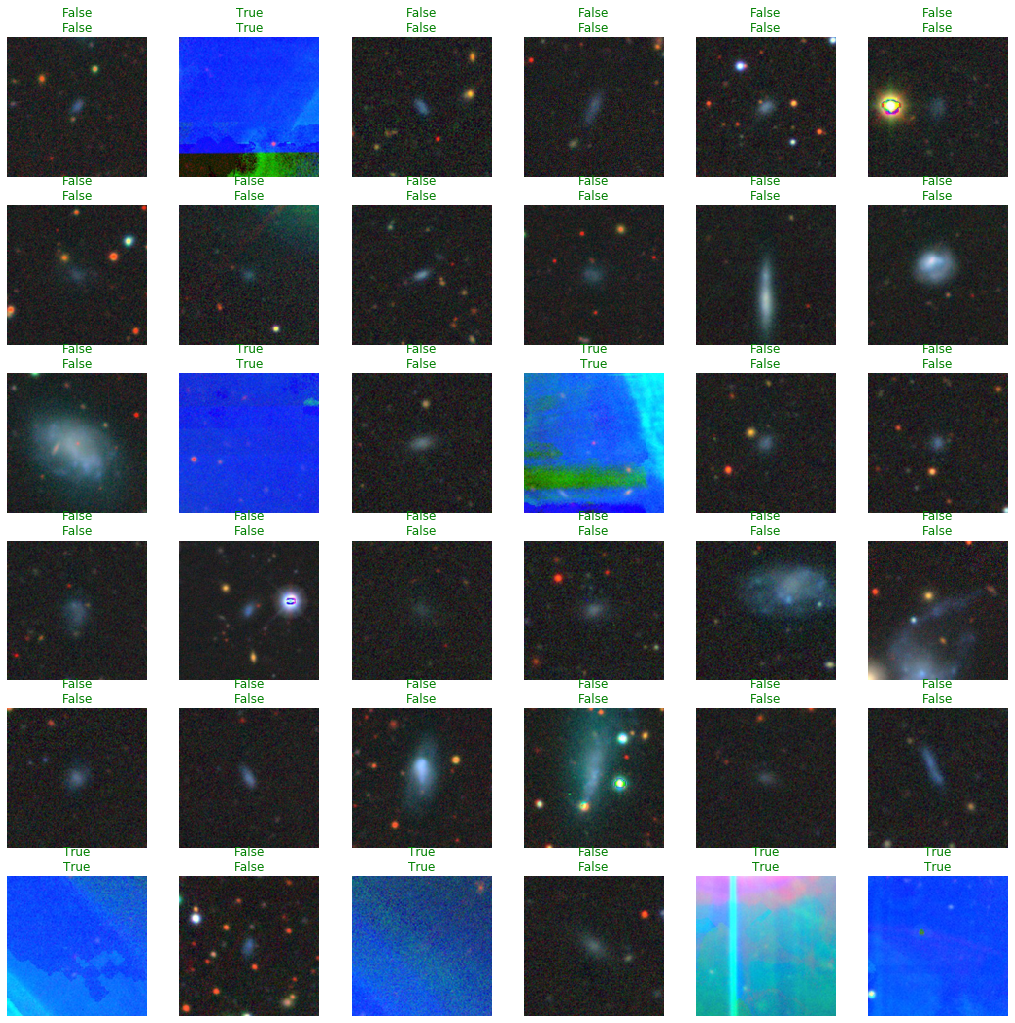

In [141]:
learn_junk.show_results(max_n=36)